In [1]:
!pip install -q open_clip_torch

In [2]:
import os
import sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

from base64 import b64encode
from torchvision import transforms
import einops
import timm
from functools import partial
import requests, io
import torch
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
from PIL import Image
from matplotlib import cm
from matplotlib import pyplot as plt
from IPython.display import display, clear_output, HTML
import numpy as np
import open_clip

from fastcore.foundation import L
import fastcore.all as fc
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *

In [3]:
#!pip install -q open_clip_torch fastcore timm

Code is from here: https://github.com/johnowhitaker/aiaiart/blob/master/AIAIART_8.ipynb (experiments section), bit refactored using callbacks for more cleaner experimentation.

## Utility funcs

In [4]:
def show_grid(maxn=20, w=3, h=3):
  """ Assuming images have been saved in steps/ and there are 
  at least maxn of them with the naming convention 0001.jpeg.
  This function loads w x h images and shows them in a grid.
  Useful for a quick preview to see if anything interesting is 
  happening"""
  fig, axs = plt.subplots(h, w)
  plt.tight_layout()
  for x in range(h):
    for y in range(w):
      i = int(maxn * (x*w+y)/(w*h))
      axs[x][y].imshow(Image.open(f'steps/{i:05}.jpeg'))

def render(ca, n=100, w=256, h=256, save_every=1, exp_frac=0, display_grid=True):
  """ Render n steps of a ca starting from a random grid.
  Saves an image every save_every steps into the steps/ folder.
  Smooths the aniation with exponential averaging set by exp_frac
  """
  !rm -r steps
  !mkdir steps
  grid = torch.rand(1, 1, w, h) # bs, channels, w, h
  im_array = np.array(grid[0][0].clip(0, 1))
  for i in tqdm(range(n)):
    grid = ca(grid)
    im_array = exp_frac*im_array + (1-exp_frac)*np.array(grid[0][0].clip(0, 1))
    im = Image.fromarray(np.uint8(cm.gist_earth(im_array)*255)).convert('RGB')
    if i % save_every == 0:
      im.save(f'steps/{i//save_every:05}.jpeg')
  if display_grid:
    show_grid(maxn=30, w=3, h=2)

def progress_video():
  # Turn the images in steps/ into a video with ffmpeg
  !ffmpeg -y -v 0 -framerate 24 -i steps/%05d.jpeg video.mp4

  # Display it inline
  mp4 = open('video.mp4','rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=256 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)


def imread(url, max_size=None, mode=None):
    if url.startswith(('http:', 'https:')):
            # wikimedia requires a user agent
            headers = {
              "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
            }
            r = requests.get(url, headers=headers)
            f = io.BytesIO(r.content)
    else:
            f = url
    img = Image.open(f).convert('RGB')
    if max_size is not None:
            img.thumbnail((max_size, max_size), Image.ANTIALIAS)
    if mode is not None:
            img = img.convert(mode)
    img = np.float32(img)/255.0
    return img

## Device

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Text prompt class

In [6]:
# Load a clip model:
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')
clip_model.to(device)
# We need to know how to transform a tensor of images to feed to CLIP:
clip_tfms = T.Compose(preprocess.transforms[:2]+preprocess.transforms[-1:]) 

# Create some dummy images and texts:
# images = torch.randn(4, 3, 256, 256).to(device) # batch of 4 random ims
# texts = open_clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

# # Encode both with CLIP
# image_features = clip_model.encode_image(clip_tfms(images))
# text_features = clip_model.encode_text(texts)

# # Check the shapes of the resulting embeddings:
# image_features.shape, text_features.shape

In [7]:
# Let's make a quick way to score a batch of images based on a prompt
class TextPrompt(nn.Module):
      def __init__(self, prompt_text):
        super(TextPrompt, self).__init__()
        self.prompt_text = prompt_text
        with torch.no_grad():
          tokenized_text = open_clip.tokenize([prompt_text]).to(device)
          self.prompt_embed = clip_model.encode_text(tokenized_text)

        # As a bonus, we can do some augmentation
        self.aug_tfms = T.Compose([
            T.RandomResizedCrop(224),
            T.RandomAffine(5),
            T.ColorJitter(),
            T.GaussianBlur(5)])
    
      def forward(self, x, augment=True, return_mean=True):
        """Take a batch of images (x), encode them with clip_model
        and score each with the prompt using Squared Great Circle Distance
        Lower is better."""
        if augment:
          x = self.aug_tfms(x)
        image_embeds = clip_model.encode_image(clip_tfms(x))
        input_normed = F.normalize(image_embeds.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.prompt_embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) # Squared Great Circle Distance
        if return_mean:
            return dists.mean()
        return dists

## Style loss

In [8]:
# vgg16 = models.vgg16(pretrained=True).to(device).features

# def calc_styles(imgs):
#     style_layers = [1, 6, 11, 18, 25]  
#     mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None].to(device)
#     std = torch.tensor([0.229, 0.224, 0.225])[:,None,None].to(device)
#     x = (imgs-mean) / std
#     grams = []
#     for i, layer in enumerate(vgg16[:max(style_layers)+1]):
#         x = layer(x)
#         if i in style_layers:
#             h, w = x.shape[-2:]
#             y = x.clone()  # workaround for pytorch in-place modification bug(?)
#             gram = torch.einsum('bchw, bdhw -> bcd', y, y) / (h*w)
#             grams.append(gram)
#     return grams

# def calc_style_loss(grams_x, grams_y):
#     loss = 0.0
#     for x, y in zip(grams_x, grams_y):
#         loss = loss + (x-y).square().mean()
#     return loss

# def to_nchw(img):
#     img = torch.as_tensor(img).to(device)
#     if len(img.shape) == 3:
#         img = img[None,...]
#     return img.permute(0, 3, 1, 2)

# ###refac
vgg16 = timm.create_model('vgg16', pretrained=True).to(def_device).features
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def calc_features(imgs, target_layers=[1, 6, 11, 18, 25]): 
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

# Batched version of the previous notebook's gram matrix function
def calc_grams(img, target_layers=[1, 6, 11, 18, 25]):
    return L(torch.einsum('bchw, bdhw -> cd', x, x) / (x.shape[-2]*x.shape[-1])
            for x in calc_features(img, target_layers))

class StyleLossToTarget():
    def __init__(self, target_im, target_layers=[1, 6, 11, 18, 25]):
        fc.store_attr()
        with torch.no_grad(): self.target_grams = calc_grams(target_im[None], target_layers)
    def __call__(self, input_im): 
        return sum((f1-f2).pow(2).mean() for f1, f2 in 
               zip(calc_grams(input_im, self.target_layers), self.target_grams))

## NeuralCA

In [9]:
# class NeuralCA(nn.Module):
#     def __init__(self, n_channels=4, hidden_n=6, zero_w2=True, device=device):
#         super().__init__()

#         # The hard-coded filters:
#         self.filters = torch.stack([torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]),
#               torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]),
#               torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]).T,
#               torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])]).to(device)
#         self.n_filters = 4
#         # Want to try using learnable filters? Uncomment:
#         # self.filters = nn.Parameter(torch.randn(self.n_filters, 3, 3))
#         self.chn = n_channels
#         self.w1 = nn.Conv2d(n_channels*self.n_filters, hidden_n, 1).to(device)
#         self.relu = nn.ReLU()
#         self.w2 = nn.Conv2d(hidden_n, n_channels, 1, bias=False).to(device)
#         if zero_w2:
#               self.w2.weight.data.zero_()
#         self.device = device

#     def perchannel_conv(self, x, filters):
#         '''filters: [filter_n, h, w]'''
#         b, ch, h, w = x.shape
#         y = x.reshape(b*ch, 1, h, w)
#         y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
#         y = torch.nn.functional.conv2d(y, filters[:,None])
#         return y.reshape(b, -1, h, w)
    
#     def forward(self, x, update_rate=0.5):
#         y = self.perchannel_conv(x, self.filters)
#         y = self.w2(self.relu(self.w1(y)))
#         b, c, h, w = y.shape
#         update_mask = (torch.rand(b, 1, h, w).to(self.device)+update_rate).floor()
#         return x+y*update_mask
  
#     def to_rgb(self, x):
#         return x[...,:3,:,:]+0.5

#     def make_video(self, x, n_steps=100):
#         !mkdir -p steps
#         !rm steps/*
#         for i in range(n_steps):
#             with torch.no_grad():
#                 x = ca(x)
#                 img = ca.to_rgb(x).detach().cpu().clip(0, 1).squeeze().permute(1, 2, 0)
#                 img = Image.fromarray(np.array(img*255).astype(np.uint8))
#                 img.save(f'steps/{i:05}.jpeg')
#         return progress_video()

#     def seed(self, n, sz=128):
#         """Initializes n 'grids', size sz. In this case all 0s."""
#         return torch.zeros(n, self.chn, sz, sz).to(self.device)
    
    
######################refac
filters = torch.stack([
    tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]),
    tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]),
    tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]).T,
    tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])
]).to(def_device)

n_channels=8 
def make_grids(n, sz=128, num_channels=8): 
    return torch.zeros(n, num_channels, sz, sz).to(def_device)

def perchannel_conv(x, filters):
    '''filters: [filter_n, h, w]'''
    b, ch, h, w = x.shape
    y = x.reshape(b*ch, 1, h, w)
    y = F.pad(y, [1, 1, 1, 1], 'circular') # << Note pad mode
    y = F.conv2d(y, filters[:,None])
    return y.reshape(b, -1, h, w)

class NeuralCA(nn.Module):
    def __init__(self, zero_w2=True, hidden_n=64, num_channels=8):
        super().__init__()
        self.w1 = nn.Conv2d(num_channels*4, hidden_n, 1)
        self.chn = num_channels
        self.relu = nn.ReLU()
        self.w2 = nn.Conv2d(hidden_n, num_channels, 1, bias=False) #TODO
        if zero_w2: self.w2.weight.data.zero_()

    def forward(self, x, update_rate=0.5):
        y = perchannel_conv(x, filters) # Apply the filters
        y = self.w2(self.relu(self.w1(y))) # pass the result through our 'brain'
        b, c, h, w = y.shape
        update_mask = (torch.rand(b, 1, h, w).to(x.device)+update_rate).floor() # Random update
        return x+y*update_mask
    
    def to_rgb(self, x):
        return x[...,:3,:,:]+0.5
    
    def make_video(self, x, n_steps=100):
        !mkdir -p steps
        !rm steps/*
        for i in range(n_steps):
            with torch.no_grad():
                x = self(x)
                img = self.to_rgb(x).detach().cpu().clip(0, 1).squeeze().permute(1, 2, 0)
                img = Image.fromarray(np.array(img*255).astype(np.uint8))
                img.save(f'steps/{i:05}.jpeg')
        return progress_video()

    def seed(self, n, sz=128):
        """Initializes n 'grids', size sz. In this case all 0s."""
        return torch.zeros(n, self.chn, sz, sz).to(self.device)

In [10]:
class LengthDataset():
    def __init__(self, length=1): self.length=length
    def __len__(self): return self.length
    def __getitem__(self, idx): return 0,0

def get_dummy_dls(length=100):
    return DataLoaders(DataLoader(LengthDataset(length), batch_size=1),
                       DataLoader(LengthDataset(1), batch_size=1))

In [11]:
class NCAProgressCB(ProgressCB):
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if not (hasattr(learn, 'metrics') and learn.training): return 
        self.losses.append(learn.loss.item())
        mbar = self.mbar
        if not hasattr(mbar, 'graph_fig'):
            mbar.graph_fig, mbar.graph_axs = plt.subplots(1, 2, figsize=(12, 3.5))
            mbar.graph_out = display(mbar.graph_fig, display_id=True)

        # Update preview image every 64 iters
        if (len(self.losses))%64 != 10: return 
        
        # Plot losses:
        mbar.graph_axs[0].clear()
        mbar.graph_axs[0].plot(self.losses, '.', alpha=0.3)
        mbar.graph_axs[0].set_yscale('log')
        mbar.graph_axs[0].set_ylim(tensor(self.losses).min(), self.losses[0])
        
        # Show preview images:
        rgb = learn.model.to_rgb(learn.preds.detach()).clip(0, 1)#.permute([0, 2, 3, 1])
        show_image(torchvision.utils.make_grid(rgb), ax=mbar.graph_axs[1])
        
        # Update graph
        mbar.graph_out.update(mbar.graph_fig)

In [21]:
class NCACB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, ca, text_prompt, n_channels=8, style_loss_scale=0.01, clip_loss_scale=3, size=256, 
                 step_n_min=32, step_n_max=96, batch_size=4):
        fc.store_attr()
        with torch.no_grad(): self.pool = make_grids(256, sz=size, num_channels=n_channels) # Set up a 'pool' of grids
    
    def predict(self, learn): 
        
        # Pick some random samples from the pool
        batch_idx = torch.randint(0, len(self.pool), (self.batch_size,))
        x = self.pool[batch_idx]
        
        # occasionally zero out some samples
        if torch.randint(8, (1,)) < 1: 
            x[:1] =  make_grids(1, sz=self.size)
        
        # Apply the model a number of times
        for _ in range(torch.randint(self.step_n_min, self.step_n_max, (1,))):
            x = learn.model(x)
        
        # Update pool
        with torch.no_grad(): self.pool[batch_idx] = x
        
        # and store preds
        learn.preds = x
        
    def get_loss(self, learn): 
        imgs=learn.model.to_rgb(self.learn.preds)
        style_loss = learn.loss_func(imgs)
        overflow_loss = (learn.preds-learn.preds.clamp(-1.0, 1.0)).abs().sum()
        clip_loss= self.clip_loss_scale*self.text_prompt(imgs)
        learn.loss = overflow_loss + style_loss*self.style_loss_scale +clip_loss
        
    def backward(self, learn):
        learn.loss.backward()
        # Gradient normalization:
        for p in learn.model.parameters():
            p.grad /= (p.grad.norm()+1e-8) 
        
    def before_fit(self, learn): self.learn=learn 

In [22]:
class BaseSchedCB(Callback):
    def __init__(self, sched): 
        self.sched = sched
        
    def before_fit(self, learn): 
        self.schedo = self.sched(learn.opt)
        
    def step_(self, learn):
        if learn.training: 
            self.schedo.step()
        
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn):
        self.step_(learn) 

In [23]:
# def download_image(url):
#     imgb = fc.urlread(url, decode=False) 
#     return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255.
# url = "https://www.artmajeur.com/medias/standard/l/a/laff/artwork/11425511_img-20180825-160133.jpg"
# #url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"
# style_im = download_image(url).to(def_device)
# style_im.shape

In [24]:
#style_url = "https://www.artmajeur.com/medias/standard/l/a/laff/artwork/11425511_img-20180825-160133.jpg"
style_url= 'images/11425511_img-20180825-160133.jpg'

style_img = imread(style_url, max_size=128)
style_img=torch.tensor(style_img)
# style_img=to_nchw(style_img)
style_img.shape

/tmp/ipykernel_1498/2391169777.py:58: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img.thumbnail((max_size, max_size), Image.ANTIALIAS)


torch.Size([126, 128, 3])

In [25]:
# target_style = calc_styles(to_nchw(style_img))
# len(target_style)

In [26]:
# target_style[0][0]

In [27]:
# pr=StyleLossToTarget(style_img.permute([2,1,0]).to('cuda'))
# pr.target_grams[0]

In [43]:
#prompt
text = 'Stained glass window' #@param
text = 'rocky montain' #@param
text_prompt = TextPrompt(text)

In [47]:
model = NeuralCA(num_channels=8).to(def_device)

# style_loss = StyleLossToTarget(style_im)
style_loss=StyleLossToTarget(style_img.permute([2,1,0]).to('cuda'))
opt_func=torch.optim.Adam
lr_sched_func = partial(torch.optim.lr_scheduler.MultiStepLR, milestones=[2000], gamma=0.3)

cbs = [NCACB(model, text_prompt=text_prompt), BatchSchedCB(lr_sched_func), NCAProgressCB(), MetricsCB()]
learn = Learner(model, get_dummy_dls(1000), style_loss, lr=1e-3, cbs=cbs, opt_func=opt_func)

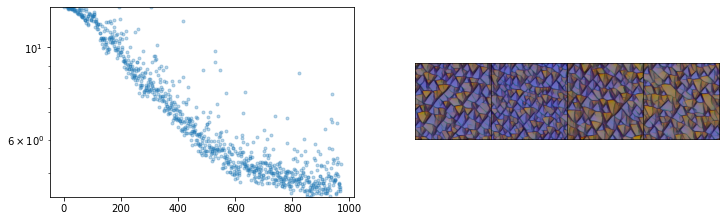

/tmp/ipykernel_1498/3282551015.py:18: UserWarning: Attempting to set identical bottom == top == 12.487054824829102 results in singular transformations; automatically expanding.
  mbar.graph_axs[0].set_ylim(tensor(self.losses).min(), self.losses[0])


In [48]:
learn.fit(1)

In [49]:
learn.model.device='cuda'
x = learn.model.seed(1)

learn.model.make_video(x, n_steps=200)

## Make example picture and video

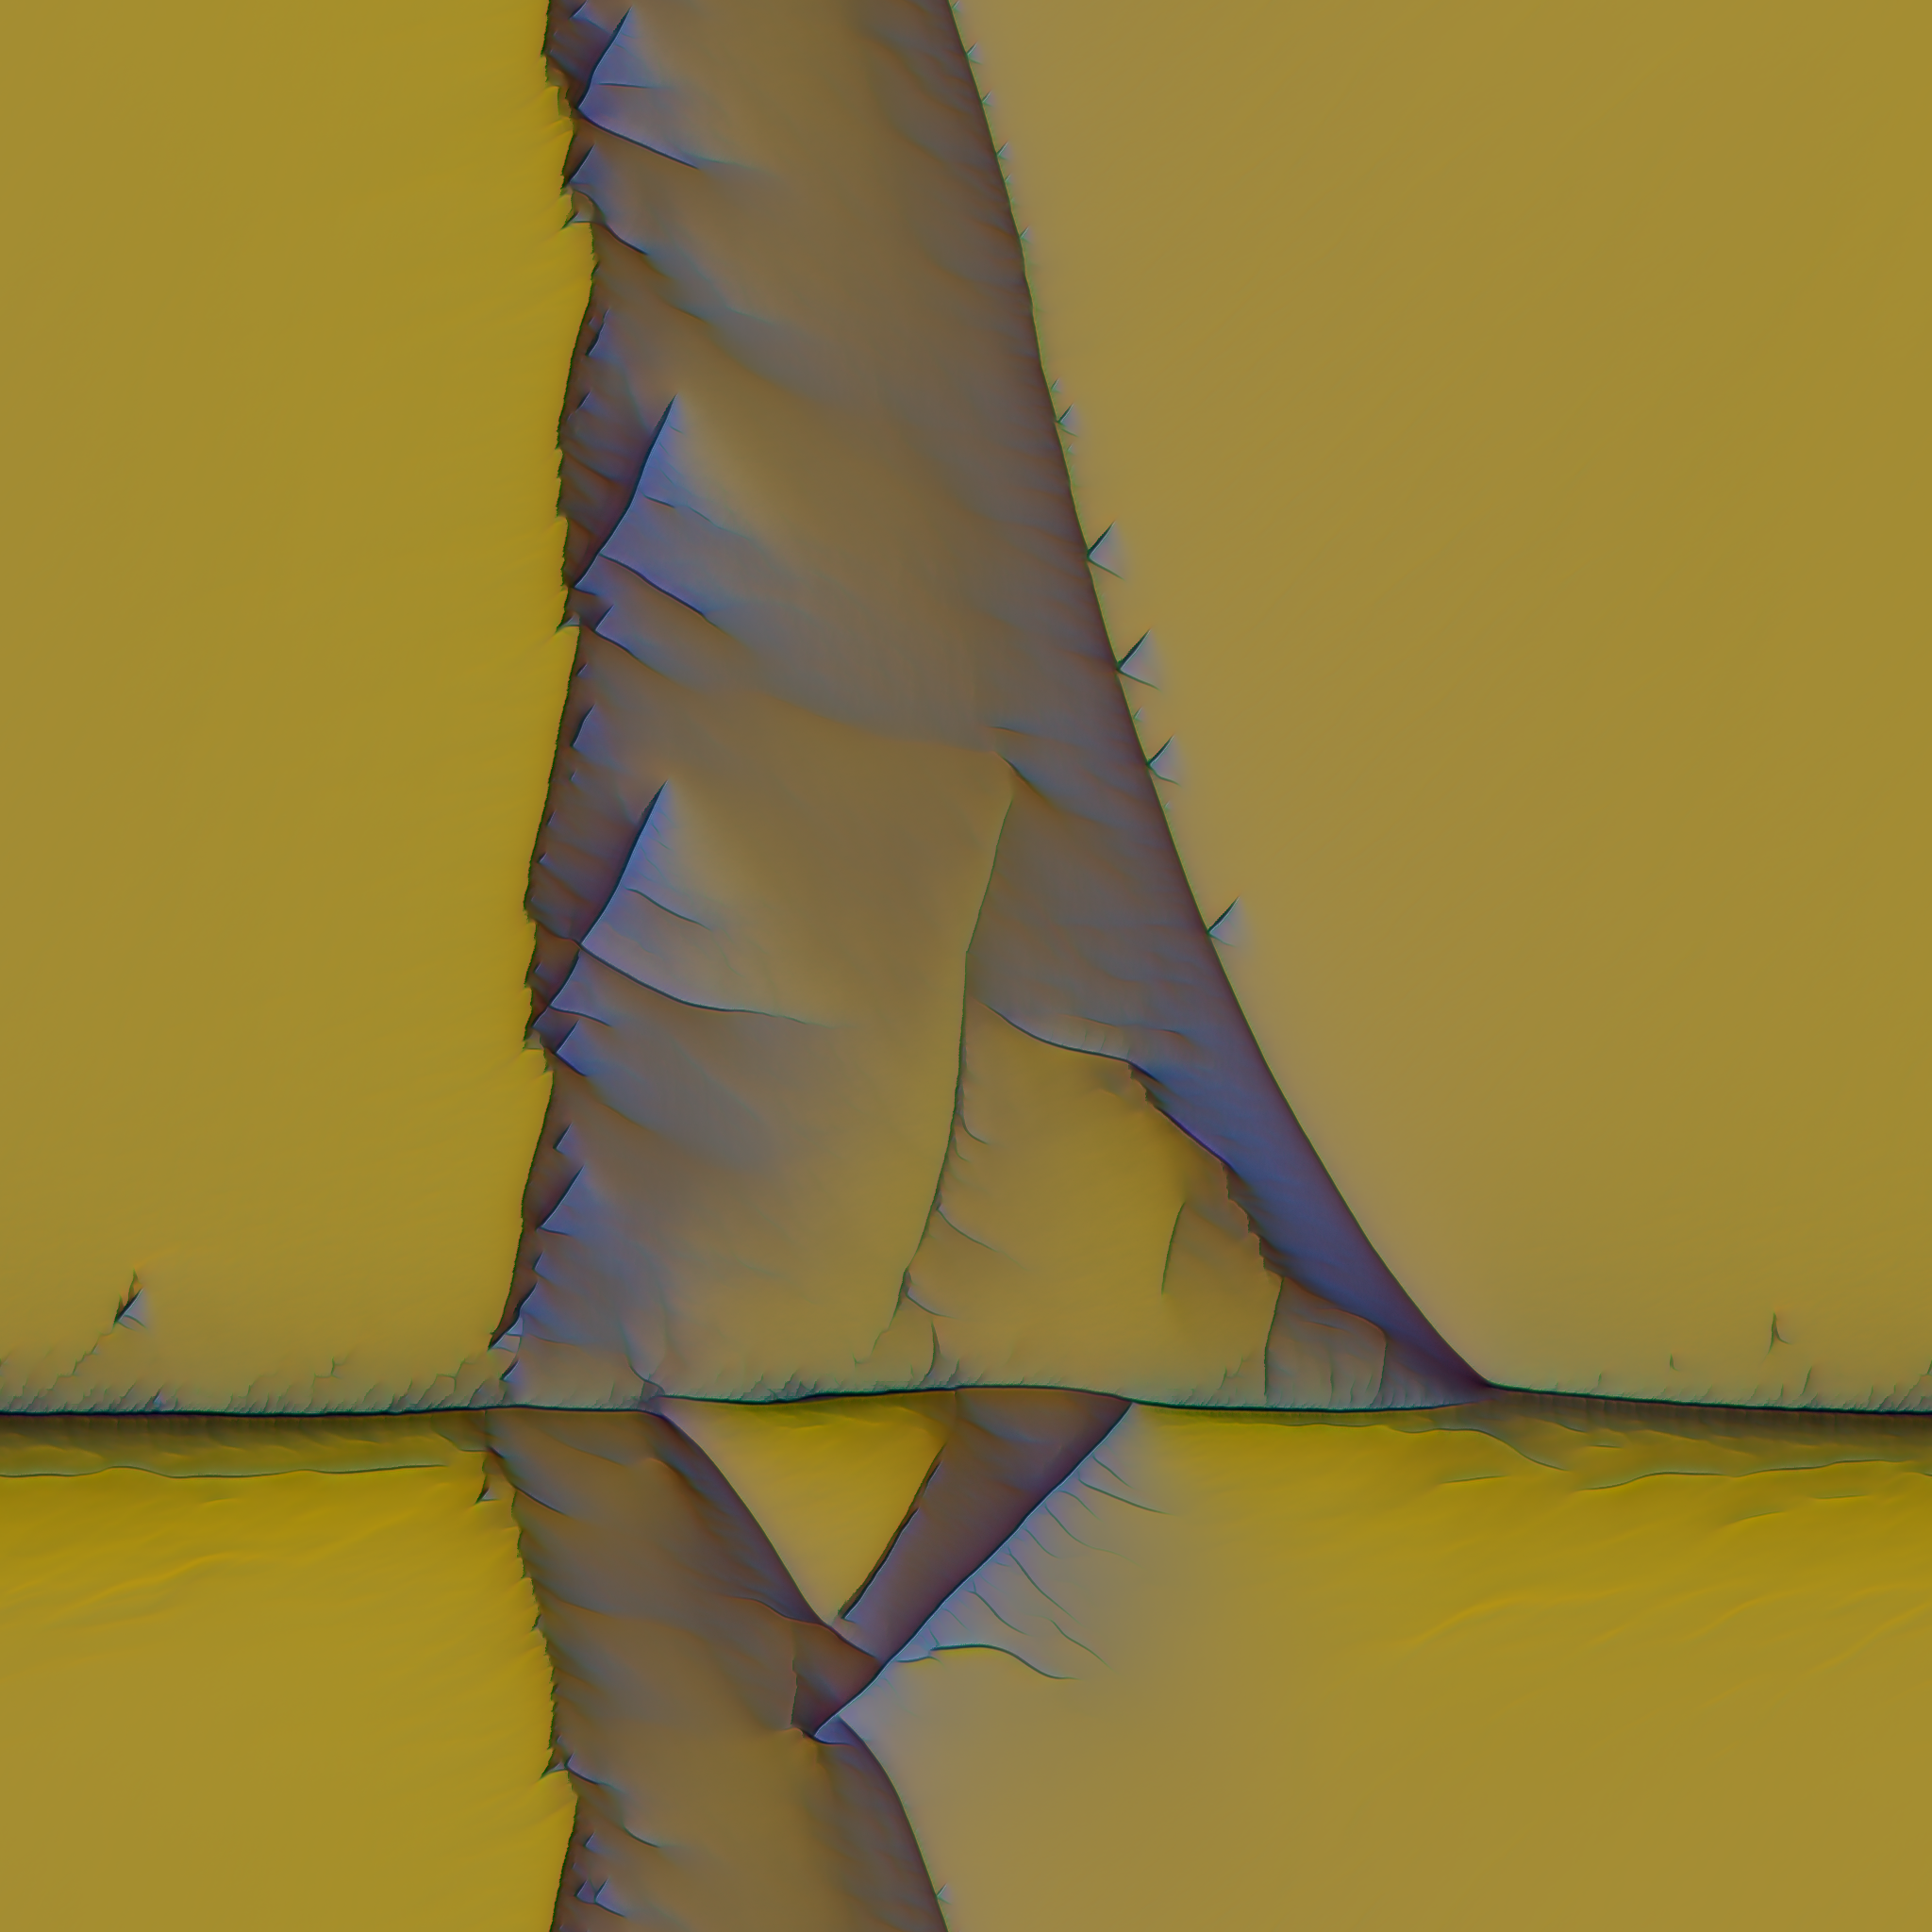

In [50]:
#@markdown Starting at low res and scaling up at certain milestones:
scaleup = nn.Upsample(scale_factor=2)
grid = learn.model.seed(1, sz=16)
for i in range(1, 950):
  with torch.no_grad():
    grid = learn.model(grid)
    if i in [300, 600, 700, 750, 800, 850, 900]:
      grid = scaleup(grid)
img = learn.model.to_rgb(grid).detach().cpu().clip(0, 1).squeeze().permute(1, 2, 0)
Image.fromarray(np.array(img*255).astype(np.uint8))

In [51]:
import torchvision.transforms as T
!rm -r zoomies/
!mkdir -p zoomies
zf=1
preview_scale = nn.Upsample(size=512, mode='bilinear')
grid = learn.model.seed(1, sz=32)
for i in range(1, 256*10):
  with torch.no_grad():
    grid = learn.model(grid)
    if i%256 == 0:
      grid = scaleup(grid)
    if grid.shape[2]>512:
      grid = grid[:,:,zf:-zf,zf:-zf]

    if i%4==0:
      img = learn.model.to_rgb(preview_scale(grid)).detach().cpu().clip(0, 1).squeeze().permute(1, 2, 0)
      Image.fromarray(np.array(img*255).astype(np.uint8)).save(f'zoomies/{i//4:05}.png')

# Turn the images in steps/ into a video with ffmpeg
!ffmpeg -y -v 0 -framerate 24 -i zoomies/%05d.png video.mp4

# Display it inline
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=512 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
#number or params in model
sum(p.numel() for p in learn.model.parameters()) # !!